# Importing dataset

In [1]:
# Importing modules
import pandas as pd
 
# Read data into df
df = pd.read_csv(r"C:\Users\Venkat Dyagala\Downloads\eclipse_jdt.csv")   # eclipse_jdk.csv
df = df.drop(columns=['Duplicated_issue'])
# Print head
df.head()


,Issue_id,Priority,Component,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1518,P1,Debug,Icons needed for actions (1GI5UXW),JGS (8/8/01 5:20:19 PM); \tWe need enabled; di...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2001-10-18 11:51:14 -0400
1,1519,P3,Debug,README: Hit count not reset (1GET20Y),JGS (6/4/01 11:43:47 AM); \tSet a breakpoint i...,RESOLVED,WORKSFORME,2.0,2001-10-10 22:14:00 -0400,2001-11-28 13:42:46 -0500
2,1520,P3,Debug,Use styled text in console (1G9S1YF),DW (2/26/01 5:56:36 PM); \tCould allow users t...,CLOSED,WONTFIX,2.0,2001-10-10 22:14:00 -0400,2002-06-26 11:32:05 -0400
3,1521,P3,Debug,StringBuffer representation (1GE3BFA),JGS (5/21/01 2:09:10 PM); \tTo be consistent; ...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2002-02-05 10:37:09 -0500
4,1522,P2,Debug,Feature: use #toString to display variable val...,DW (9/27/00 11:12:31 AM); \tCurrently; the typ...,RESOLVED,DUPLICATE,2.0,2001-10-10 22:14:00 -0400,2001-10-17 10:17:47 -0400


# Plotting priority field

<AxesSubplot:xlabel='Priority'>

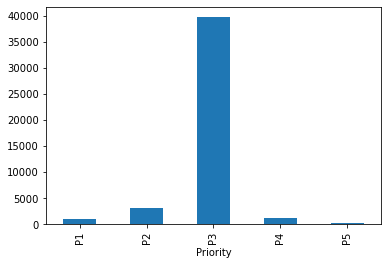

In [2]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

# Plotting component

<AxesSubplot:xlabel='Component'>

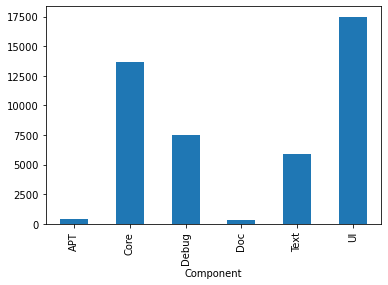

In [3]:
df['Component'].value_counts().sort_index().plot(kind='bar')

# Removing odd words

In [17]:
import html
import re
def clean(text):
    # convert html escapes like & to characters.
    text = html.unescape(text) 
    # tags like 
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches  but not #cool
    text = re.sub(r'(?:^|\s)[<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Data cleaning

In [5]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description']) 
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2)

,Priority,text
24756,P3,Spurious warning with generics (maybe) The cod...
22322,P3,Problem on refactoring I have a Java Eclipse p...


# Traning to Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


# Converting X train into numbers

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

# Initializing model

In [8]:
from sklearn.svm import LinearSVC

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

# Getting accurate value

In [9]:
from sklearn.metrics import accuracy_score

Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


# Dummy classifier

In [10]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.8769281988680502


# Confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]], dtype=int64)

# Plotting confusion matrix

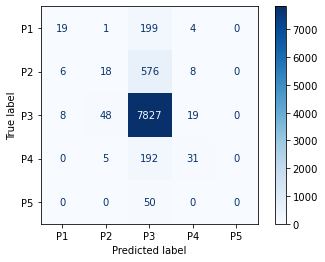

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay as CMD
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, Y_pred)
disp = CMD(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report

In [13]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

C:\Users\Venkat Dyagala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Venkat Dyagala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



C:\Users\Venkat Dyagala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Down sampling

In [14]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

Priority
P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: count, dtype: int64

# Repeat everything

In [15]:
# Loading the balanced dataframe

df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909
Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



# Finding the better way

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True
# Loading the dataframe
df = pd.read_csv(r"C:\Users\Venkat Dyagala\Downloads\eclipse_jdt.csv")
df = df.drop(columns=['Duplicated_issue'])
df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])
# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)
# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Component'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Component'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])
# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")
if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(X_train, Y_train)
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7208
Size of Test Data  1802
